In [1]:
%matplotlib notebook
import nivapy
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from shapely.geometry import Point
from mpl_toolkits.mplot3d import Axes3D

# Inlay Lake bathymetry

## 1. Read survey data

In [2]:
# Read survey data
in_xlsx = (r'C:\Data\James_Work\Staff\Andreas_B\Inle_Lake_Bathymetry'
           r'\Inle_Water_Depth_Survey.xlsx')
df = pd.read_excel(in_xlsx, sheetname='tidied')
df['tran_point'] = df['tran_point'].astype(str)

print 'Number of survey points:', len(df)
df.head()

Number of survey points: 211


,point_id,transect,tran_point,Datetime,Lat,Lon,Depth_m
0,1,1,1.1,2017-11-29 09:23:00,20.60330,96.89389,1.7
1,2,1,1.2,2017-11-29 09:48:00,20.60290,96.89573,2.0
2,3,1,1.3,2017-11-29 09:53:00,20.60268,96.89770,2.0
3,4,1,1.4,2017-11-29 09:55:00,20.60273,96.89964,2.2
4,5,1,1.5,2017-11-29 10:00:00,20.60306,96.90153,2.2


## 2. Basic map

Check that the data plot in the correct loaction (zoom in to see Inlay Lake).

In [3]:
# Map
map1 = nivapy.spatial.quickmap(df, lon_col='Lon', lat_col='Lat', 
                               popup='tran_point', 
                               tiles='Open Streetmap')
map1

## 3. Projection for interpolation

For spatial interpolation, we need to use a projected co-ordinate system rather than a geographic one (because interpolation of lat/lon co-ordinates can lead to distortion). As the area of interest is small, it shouldn't matter too much which projection we choose.

First, get the max and min lat and lon co-ordinates to define the area of interest.

In [4]:
# Max and min for co-ords
df.describe()

,point_id,transect,Lat,Lon,Depth_m
count,211.00000,211.000000,211.000000,211.000000,211.000000
mean,106.00000,6.279621,20.552799,96.912241,2.436493
std,61.05462,4.026402,0.036648,0.011621,0.424090
min,1.00000,1.000000,20.464670,96.879490,1.100000
25%,53.50000,3.000000,20.529245,96.904920,2.200000
50%,106.00000,6.000000,20.556300,96.913890,2.400000
75%,158.50000,9.000000,20.582950,96.920620,2.700000
max,211.00000,16.000000,20.603700,96.935520,3.900000


For the work here, it is convenient to use a Mercator co-ordinate system (as then it is easy to use background tiles from e.g. Google or OSM), but first I need to check the distortion is not too great. Tissot indicatrices can be used to illustrate distortion: in reality, each indicatrix is a perfect circle, but they may appear distorted on the map. 

<IPython.core.display.Javascript object>


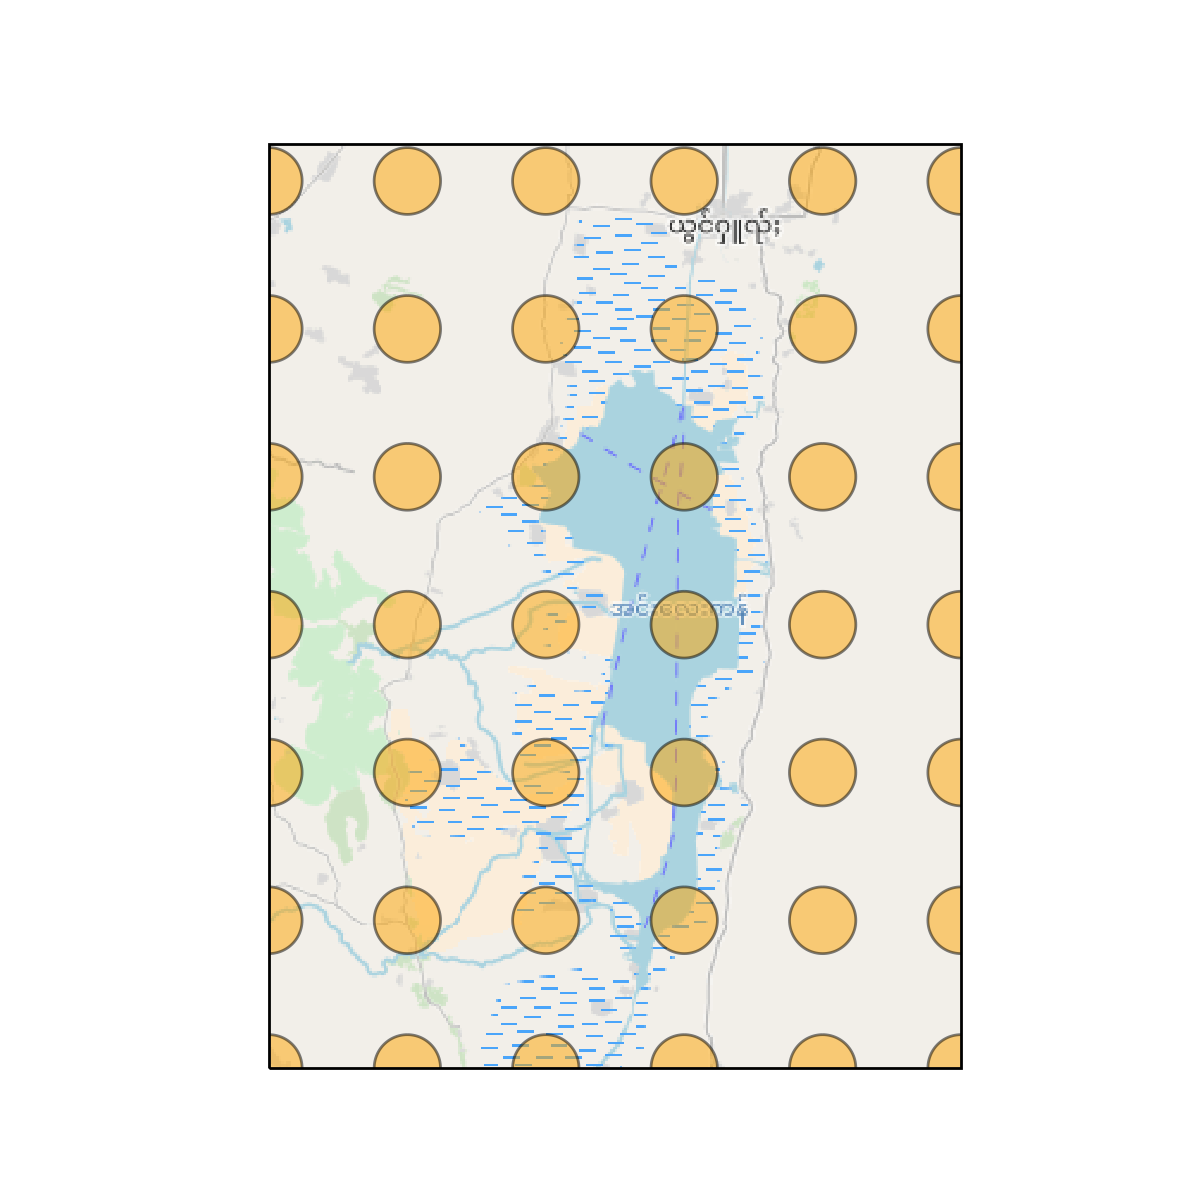

In [5]:
# Use OSM background (which uses a Mercator projection)
backgr = cimgt.OSM()

# Setup plot
fig = plt.figure(figsize=(6,6))
crs_ax = fig.add_subplot(1,1,1, projection=backgr.crs)
crs_ax.set_extent([96.8, 97.0, 20.43, 20.68]) # Extent from dataframe in lat/lon
                                              # (xmin, xmax, ymin, ymax)

# Add background data (zoom level = 11)
crs_ax.add_image(backgr, 11)

# Draw Tissot indicatrices to show distortion
lons = np.arange(96.8, 97, 0.04)
lats = np.arange(20.43, 20.68, 0.04)
crs_ax.tissot(rad_km=1000,     # Actually in metres. Fixed in v0.16?
              lons=lons, 
              lats=lats, 
              n_samples=100,      # Number of points for each circle
              facecolor='orange',
              edgecolor='black',
              alpha=0.5)

This map shows the correct area, and all of the indicatrices look like circles to me, so the distortion at this scale seems to be minimal. I will therefore use a basic Mercator projection for simplicity.

## 4. Lake boundary data

To constrain the interpolation, it is necessary to know the location of the edge of the lake. Essentially, we want to **add additional points around the shoreline of the lake with a depth equal to zero**. I have therefore downloaded a shapefile for Inlay Lake from OSM, and the code below converts to polygon to points.

In [6]:
# Read shapefile
in_shp = r'C:\Data\James_Work\Staff\Andreas_B\Inle_Lake_Bathymetry\GIS\inlay.shp'
gdf = gpd.read_file(in_shp)

# Gets points from lake edge
lats = []
lons = []
for index, row in gdf.iterrows():
     for pt in list(row['geometry'].exterior.coords): 
        lons.append(pt[0])
        lats.append(pt[1])
        
# Build df
edge_df = pd.DataFrame({'Lat':lats,
                        'Lon':lons})
edge_df['Depth_m'] = 0

print 'Number of points added to margin:', len(edge_df)
edge_df.head()

Number of points added to margin: 487


,Lat,Lon,Depth_m
0,20.576046,96.927725,0
1,20.575294,96.929683,0
2,20.574889,96.930286,0
3,20.573996,96.930148,0
4,20.573733,96.933070,0


In [7]:
# Combine edge and survey data
df2 = df[['Lat', 'Lon', 'Depth_m']]
interp_df = pd.concat([df2, edge_df], axis=0)

print 'Total number of points for interpolation:', len(interp_df)
interp_df.head()

Total number of points for interpolation: 698


,Lat,Lon,Depth_m
0,20.60330,96.89389,1.7
1,20.60290,96.89573,2.0
2,20.60268,96.89770,2.0
3,20.60273,96.89964,2.2
4,20.60306,96.90153,2.2


## 5. Detailed map

Create a map in projected co-ordinates, showing the transect locations coloured according to depth.

<IPython.core.display.Javascript object>


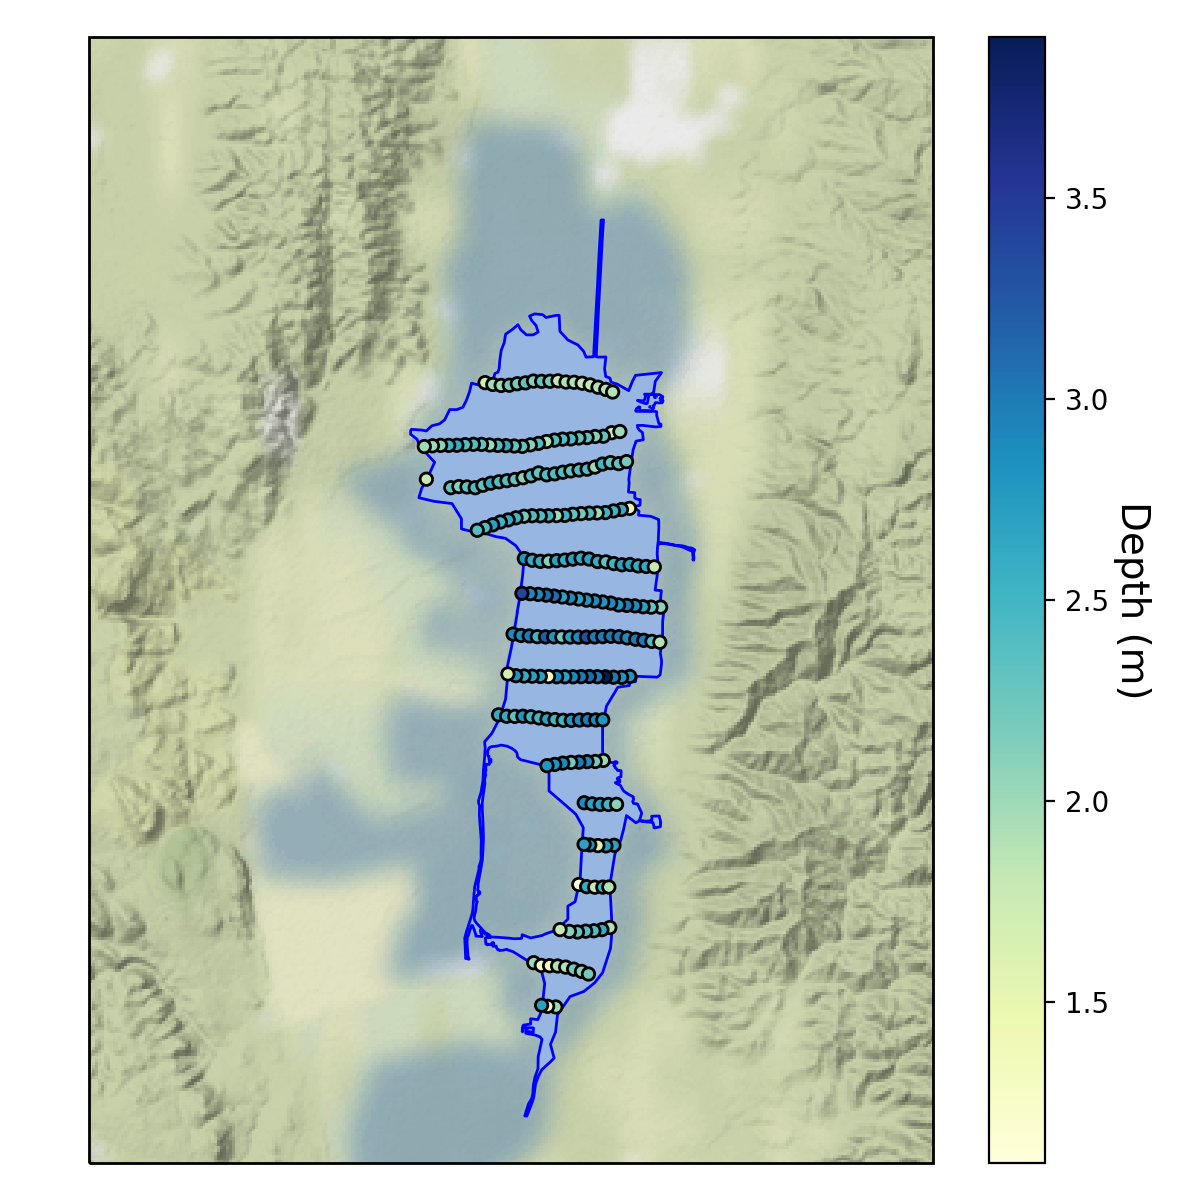

In [8]:
# Create background imagery
backgr = cimgt.StamenTerrain()#GoogleTiles(style='satellite')

# Create GeoAxes in the tile's projection.
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=backgr.crs)

# Limit the extent to lat/lon range
ax.set_extent([96.8, 97.0, 20.43, 20.68])

# Add background data
ax.add_image(backgr, 11)

# Read Inlay shapefile
in_shp = r'C:\Data\James_Work\Staff\Andreas_B\Inle_Lake_Bathymetry\GIS\inlay.shp'
reader = cartopy.io.shapereader.Reader(in_shp)
features = reader.records()

# Loop over records
for feat in features:
    # Transparent
    ax.add_geometries(feat.geometry, 
                      ccrs.PlateCarree(), # CRS shp
                      facecolor=cfeature.COLORS['water'], 
                      edgecolor='blue')

# Add points using linear colour ramp   
cax = ax.scatter(df['Lon'].values, 
                 df['Lat'].values, 
                 c=df['Depth_m'].values, 
                 cmap='YlGnBu', 
                 s=20, 
                 edgecolors='k', 
                 zorder=5,
                 transform=ccrs.PlateCarree())
cbar = fig.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Depth (m)', rotation=270, fontsize=14)
plt.tight_layout()

## 6. Perform interpolation

In [9]:
# Cell size (metres)
cell_size = 200.

# Extent in metres for map proj
xmin, xmax, ymin, ymax = [round(i / cell_size) * cell_size for i in ax.get_extent()]

# Setup grid for interpolation (shift by (cell_size/2) s.t. values 
# are estimated for the centre of each grid square
gridx = np.arange(xmin, xmax, cell_size) + (cell_size/2.)
gridy = np.arange(ymin, ymax, cell_size) + (cell_size/2.)

# Map (long, lat) to projected (x, y)
pts = backgr.crs.transform_points(src_crs=ccrs.PlateCarree(),
                                  x=interp_df['Lon'].values, 
                                  y=interp_df['Lat'].values)[:, :2]

# Get values to interpolate
vals = interp_df['Depth_m'].values

# Interpolate
bathym = nivapy.spatial.interp_bilinear(pts, vals, gridx, gridy)
bathym[bathym<0] = np.nan

# Save
out_path = (r'C:\Data\James_Work\Staff\Andreas_B\Inle_Lake_Bathymetry'
            r'\GIS\inlay_bathymetry_bilinear.tif')
nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, out_path, bathym.copy(), 
                              backgr.crs.proj4_init)

C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in less


## 7. Plot in 2D

<IPython.core.display.Javascript object>


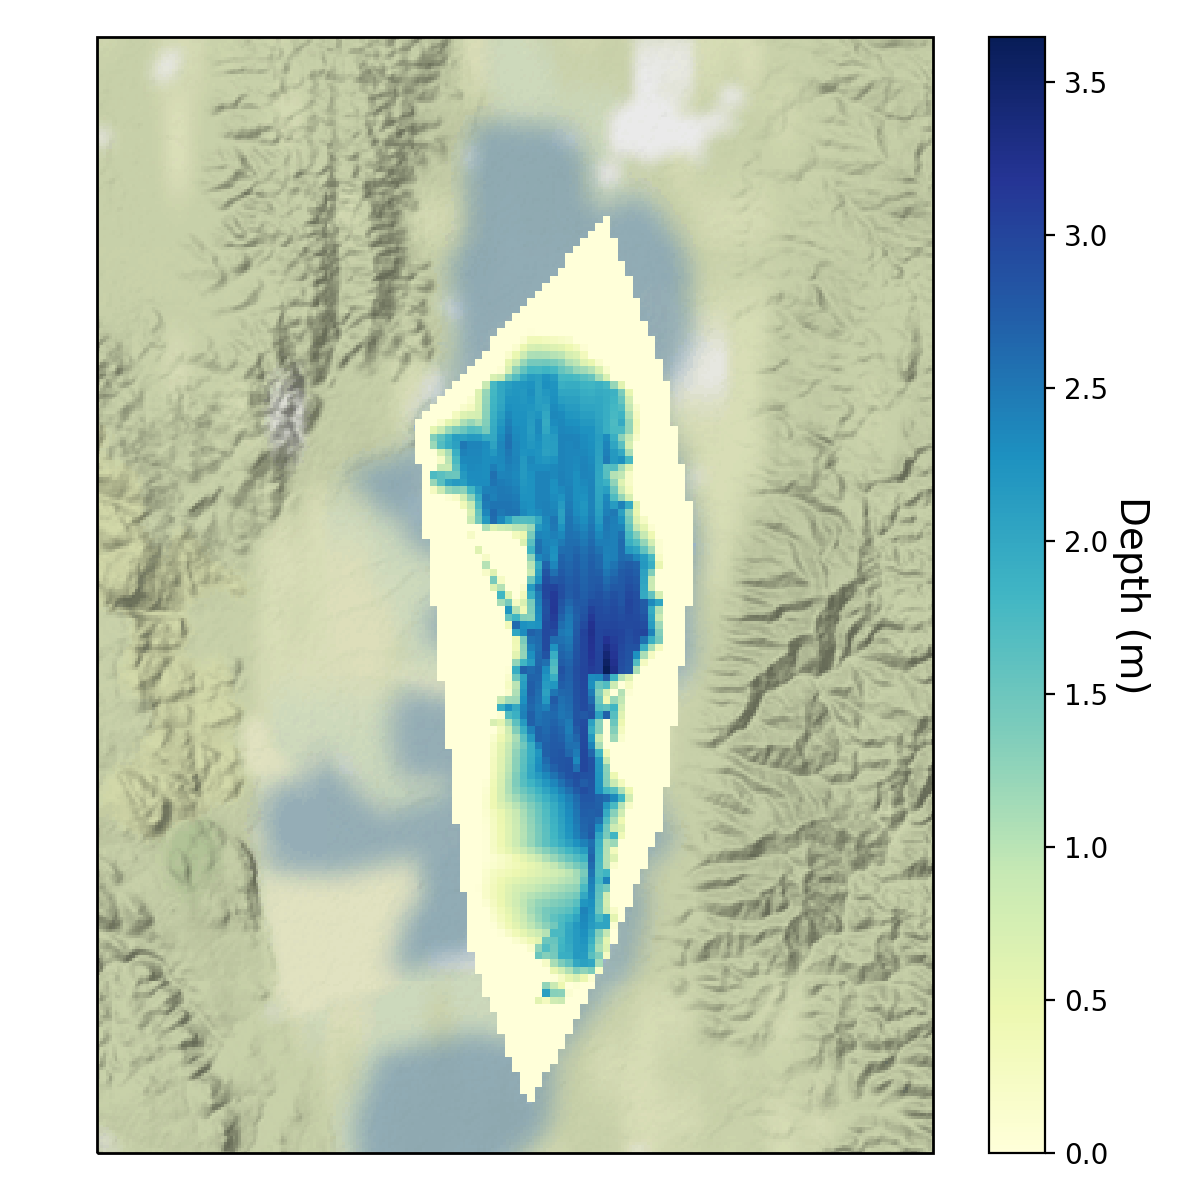

In [10]:
# Create background imagery
backgr = cimgt.StamenTerrain()#GoogleTiles(style='satellite')

# Create GeoAxes in the tile's projection.
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=backgr.crs)

# Limit the extent to lat/lon range
ax.set_extent([96.8, 97.0, 20.43, 20.68])

# Add background data
ax.add_image(backgr, 11)

# Plot array
cax = ax.imshow(bathym, 
                zorder=1,
                extent=(xmin, xmax, ymin, ymax),
                cmap='YlGnBu', 
                alpha=1, 
                interpolation='none')

cbar = fig.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Depth (m)', rotation=270, fontsize=14)
plt.tight_layout()

## 8. Plot in 3D

<IPython.core.display.Javascript object>


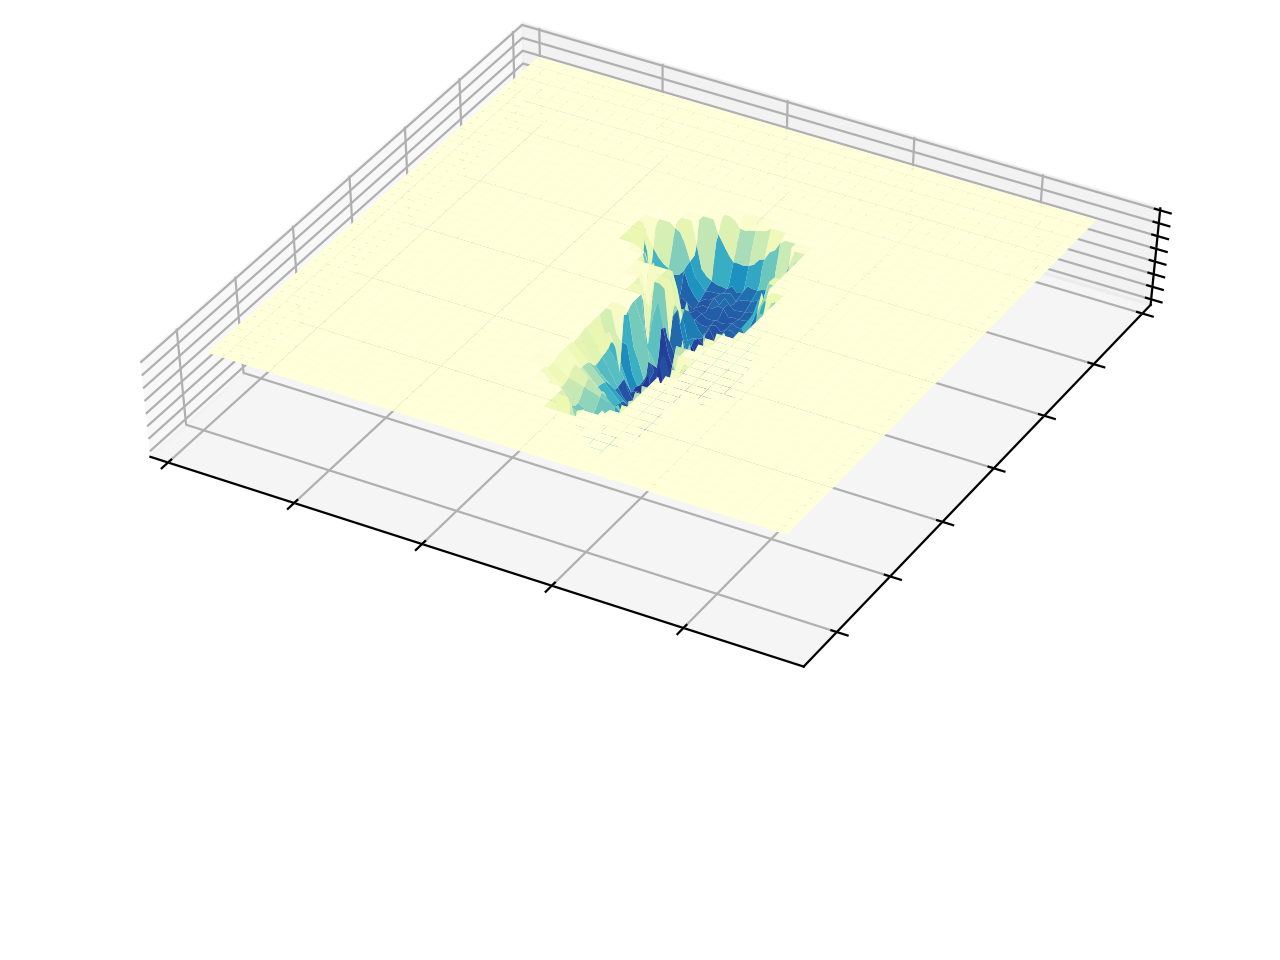

In [11]:
# Setup plot
fig = plt.figure()
ax = Axes3D(fig)

# Co-ord arrays
X, Y = np.meshgrid(gridx, gridy)

# Plot
bathym[np.isnan(bathym)] = 0
surf = ax.plot_surface(X, Y, -bathym, cmap='YlGnBu_r', 
                       antialiased=True, shade=True)
ax.set_xticklabels([''])
ax.set_yticklabels([''])
ax.set_zticklabels([''])
ax.pbaspect = [1.,1., 0.25]

An improved 3D visualisation based on the data generated above can be found [here](https://drive.google.com/file/d/13ij4E2cpeEdUCBjFj8mPgKecDskKHPXf/view?usp=sharing) (created using QGIS and the QGIS2Threejs plugin).